# Dynamic Time Warping

## Files and Data
#### ground-truth folder
Contains ground truth data.


#### transcription.txt  
- XXX-YY-ZZ: XXX = Document Number, YY = Line Number, ZZ = Word Number
- Contains the character-wise transcription of the word (letters seperated with dashes)
- Special characters denoted with s_
	- numbers (s_x)
	- punctuation (s_pt, s_cm, ...)
	- strong s (s_s)
	- hyphen (s_mi)
	- semicolon (s_sq)
	- apostrophe (s_qt)
	- colon (s_qo)
    
### Task
Three files:  
##### training and test data:
train.txt, valid.txt
both contain a list of documents
##### keywords that are at least once in the training and validation set defined by train.txt and valid.txt
keywords.txt



In [24]:
import numpy as np
from matplotlib import pyplot as plt
import PIL
import cv2
import os

In [21]:
IMAGES_PATH = "./word-images/"
DIRS = [name for name in os.listdir(IMAGES_PATH)]

#Testing
print(DIRS)

['273', '301', '279', '274', '277', '275', '302', '300', '276', '272', '304', '271', '278', '303', '270']


In [25]:
# returns list of numpy arrays with the pixel values
def import_images():
    images = list()
    for folder in DIRS:
        img_paths = IMAGES_PATH + folder
        for image in os.listdir(img_paths):
            images.append(cv2.imread(img_paths + "/" + image,0))
    return images

def display_image(image):
    plt.imshow(images[13], interpolation='nearest', cmap='gray')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [27]:
# get the transcription of all words
def get_file(filepath):
    lines = list()
    with open(filepath, 'r') as f:
        lines = f.read().splitlines()
    return lines

# unpacks a row from the transcript, return a dict with the corresponding values
def parse_transcript_row(row):
    metadata, word = row.split(" ")
    document, line, col = metadata.split("-")
    # special_char = ""
    # if "_" in word:
    #   word, special_chars = word.split("_")
    return {"document": document, "line": line, "col": col, "word": word}

# Testing
parse_transcript_row("274-20-02 C-a-t-t-l-e-s_cm")

# parse all words to usable dict
def parse_transcript(transcript):
    data = dict()
    id_counter = 0
    for row in transcript:
        data[id_counter] = parse_transcript_row(row)
        id_counter += 1
    return data
        
# Testing
transcript = np.array(["275-07-09 r-e-m-a-r-k-a-b-l-y",
                      "275-08-01 a-w-k-w-a-r-d-s_cm", "275-08-02 p-a-r-t-i-c-u-l-a-r"])
parse_transcript(transcript)

{0: {'document': '275',
  'line': '07',
  'col': '09',
  'word': 'r-e-m-a-r-k-a-b-l-y'},
 1: {'document': '275',
  'line': '08',
  'col': '01',
  'word': 'a-w-k-w-a-r-d-s_cm'},
 2: {'document': '275',
  'line': '08',
  'col': '02',
  'word': 'p-a-r-t-i-c-u-l-a-r'}}

In [39]:
# files where keywords for validation are located
VALID_DOCUMENT_IDS = get_file('valid.txt')
# files where keywords for training are located
TRAIN_DOCUMENT_IDS = get_file('train.txt')
# list of words which are present in the training set and also in the valid set
KEYWORDS = get_file('keywords.txt')

transcript_list = get_file('ground-truth/transcription.txt')
TRANSCRIPT = parse_transcript(transcript_list)

print(TRANSCRIPT[0])
print(len(TRANSCRIPT))

{'document': '270', 'line': '01', 'col': '01', 'word': 's_2-s_7-s_0-s_pt'}
3726


## Testing

### **dtaidistance:** fancy pantsy library for DTW
##### Installation:
`pip install dtaidistance`  
**github:** [github-repo for dtaidistance](https://github.com/wannesm/dtaidistance)

(<Figure size 720x720 with 4 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fae6d443650>])

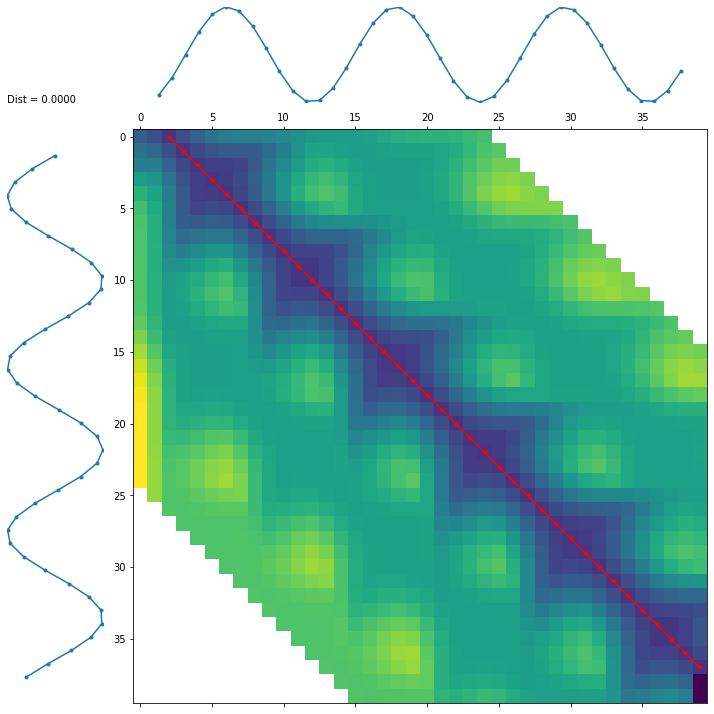

In [5]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
x = np.arange(0, 20, .5)
s1 = np.sin(x)
s2 = np.sin(x - 1)
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)


### DTW required steps
- [ ] initialize matrix
- [ ] calculate each field in the matrix
- [ ] find the shortest path from 0,0 to i,j through the matrix by iterating and increasing either i, j or both
##### Efficiency
- [ ] only calculate matrix fields within a certain treshold (Sakoe-Chiba Band)

In [5]:
### Custom DTW
def dtw(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

200


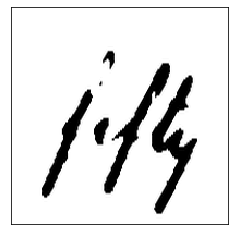

In [14]:
from PIL import Image
images = import_images()
print(len(images[0]))

# result = dtw([1,2,3], [2,2,2,2,3,4])
# print("result: " + str(result))
display_image(images[0])


#### Steps for the task
- get all images
- convert each image to a numpy array with dtype np.double

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


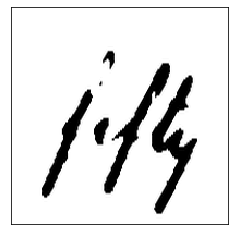

In [21]:
from PIL import Image
import numpy as np

images = import_images()

print(np.asarray(images[0]))

display_image(images[0])